<h1> Data augmentation</h1>

I just want to have a look into data augmentation as the angle distribution is not uniform. (compare stage3_analize_data)

In [1]:
# own skrips
import myfunctions as mf
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit

In [2]:
rootfile = uproot.open('./stage3_clusters_corr_newdata.root')
ipd = hf.InputData(rootfile)
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Start shaping clusters in a  (5, 5)  grid...
Shaping the clusters took  144.87712931632996 s
Splitted data into training and test set!
Prepared 'training' data
Prepared 'veri_truth' data
Prepared 'veri_fit' data


In [3]:
model = keras.models.load_model('stage3model_truely_correct_newdata')

In [4]:
output = model.predict(ipd.clusters_v)

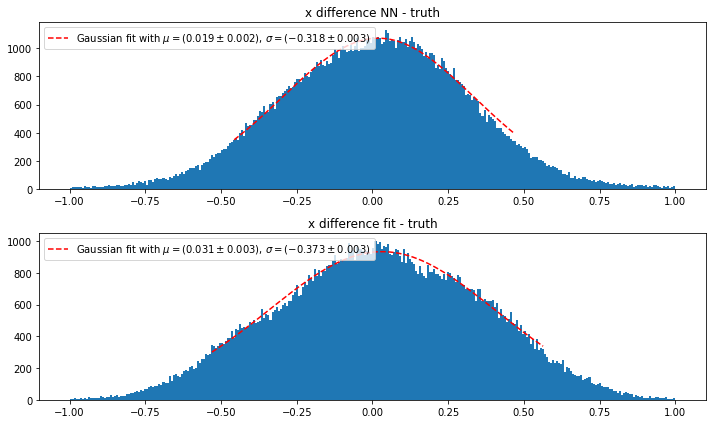

(array([ 1.90871865e-02, -3.18241688e-01,  8.53832561e+02]),
 array([1.93823991e-03, 2.75232034e-03, 5.87748676e+00]),
 array([ 3.14518854e-02, -3.73078158e-01,  8.73900140e+02]),
 array([2.50007670e-03, 3.49120271e-03, 6.53248271e+00]))

In [5]:
mf.histo_output(output.T[0], ipd.veri_fit.T[0], ipd.veri_truth.T[0], name="x", fit=True)

<h2> Ok, now look at what exactly is happening...

In [6]:
theta_x_t = np.arccos(ipd.momentum_t.T[0]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_y_t = np.arccos(ipd.momentum_t.T[1]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_z_t = np.arccos(ipd.momentum_t.T[2]/ (np.linalg.norm(ipd.momentum_t, axis=1)))
theta_x_v = np.arccos(ipd.momentum_v.T[0]/ (np.linalg.norm(ipd.momentum_v, axis=1)))
theta_y_v = np.arccos(ipd.momentum_v.T[1]/ (np.linalg.norm(ipd.momentum_v, axis=1)))
theta_z_v = np.arccos(ipd.momentum_v.T[2]/ (np.linalg.norm(ipd.momentum_v, axis=1)))

In [7]:
def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def histo_output_relxy(xy_NN, xy_truth, E_truth, theta_z_v, name='', range_x = (-0.25,0.25), bins=300, num_sig=1):
    '''similar to histo_output but written for x/y to display relative difference and return values that are more than "num_sig" times sigma away and their corresponding engery'''
    
    plt.rcParams["figure.figsize"] = (8,5)
    plt.subplot(1,1,1)
    n_counts, bins, patches = plt.hist((xy_NN-xy_truth)/xy_truth, bins=bins, range=range_x)

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers, n_counts, p0=[0,1, 100], sigma=1/np.sqrt(n_counts), maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[0], x_centers[-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.4f} \pm {:.4f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.4f} \pm {:.4f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of " + name)
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((xy_NN-xy_truth)/xy_truth) > num_sig * abs(popt1[1])) # all events further away than 1 sigma
    print("Bad indicies: ", len(ind_bad[0]))
    print("All: ", len(xy_truth))
    values_bad_xy = xy_truth[ind_bad]
    E_bad = E_truth[ind_bad]
    theta_bad = theta_z_v[ind_bad]
    
    plt.tight_layout()
    plt.show()
    
    return values_bad_xy, E_bad, theta_bad # return values that are more than 1 (num_sig) sigma away

Bad indicies:  47109
All:  125710


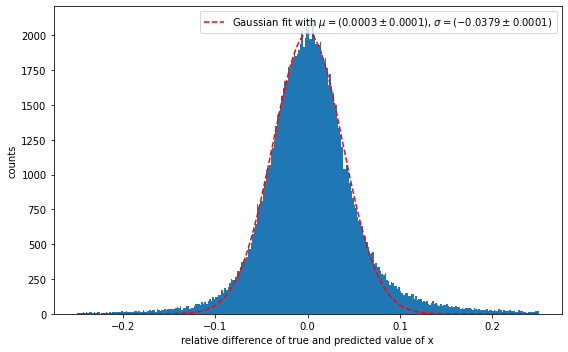

In [8]:
x_bad, Ex_bad, theta_z_xbad = histo_output_relxy(output.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], theta_z_v,name='x')

Es sollten 68,27 % aller Messwerte im Intervall $\pm \sigma$ zu finden ein.

Bad indicies:  49061
All:  125710


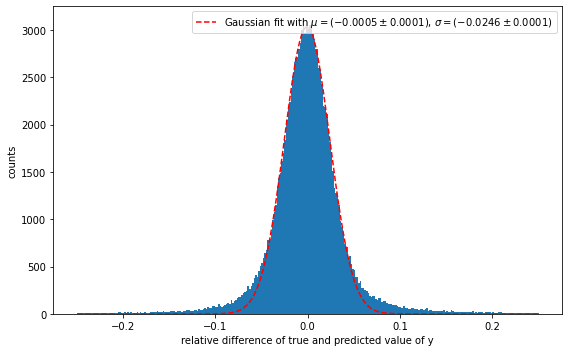

In [9]:
y_bad, Ey_bad, theta_z_ybad = histo_output_relxy(output.T[1], ipd.veri_truth.T[1], ipd.veri_truth.T[2], theta_z_v, name='y')

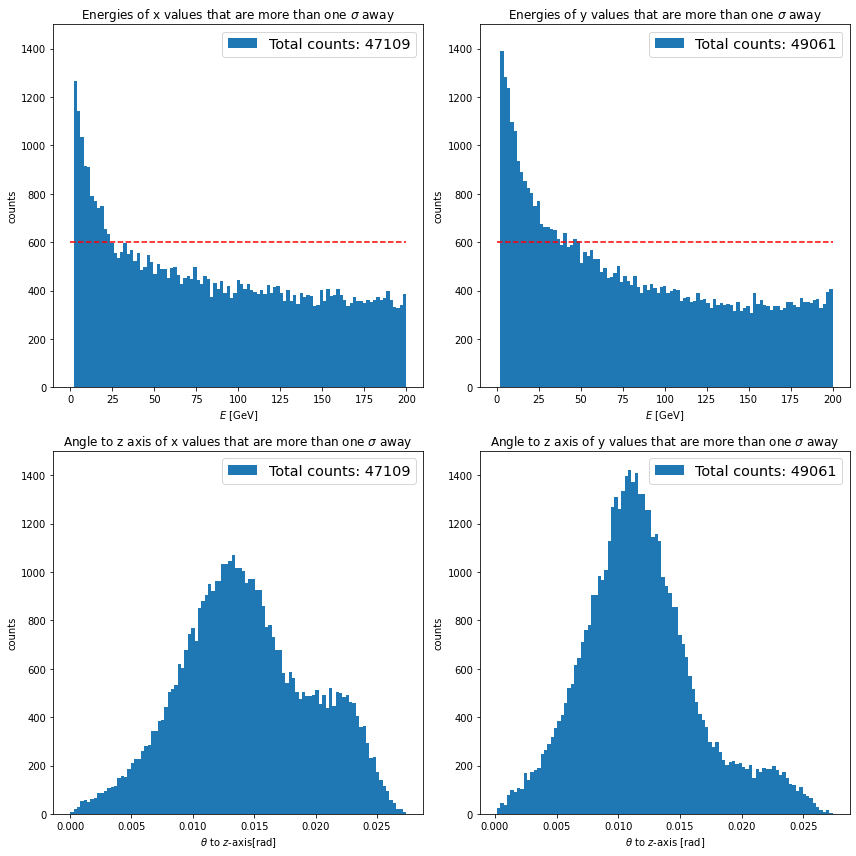

In [10]:
plt.rcParams["figure.figsize"] = (12,12)

ylim = 1500

plt.subplot(2,2,1)
plt.hist(Ex_bad, bins=100, label="Total counts: "+ str(len(Ex_bad)))
plt.legend(fontsize="x-large")
plt.title("Energies of x values that are more than one $\sigma$ away ")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(2,2,2)
plt.hist(Ey_bad, bins=100, label="Total counts: "+ str(len(Ey_bad)))
plt.legend(fontsize="x-large")
plt.title("Energies of y values that are more than one $\sigma$ away ")
plt.xlabel("$E$ [GeV]")
plt.ylabel("counts")
plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(2,2,3)
plt.hist(theta_z_xbad, bins=100, label="Total counts: "+ str(len(theta_z_xbad)))
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis[rad]")
plt.ylabel("counts")
#plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.subplot(2,2,4)
plt.hist(theta_z_ybad, bins=100, label="Total counts: "+ str(len(theta_z_ybad)))
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("counts")
#plt.hlines(600, 0, 200, 'r', linestyles="dashed")
plt.ylim(0, ylim)

plt.tight_layout()
plt.show()

Ok this is nearly correct. Now weight all the bins with inertial amought of entries...

In [11]:
hist_E, bin_edge = np.histogram(ipd.E_truth_veri, bins=100)

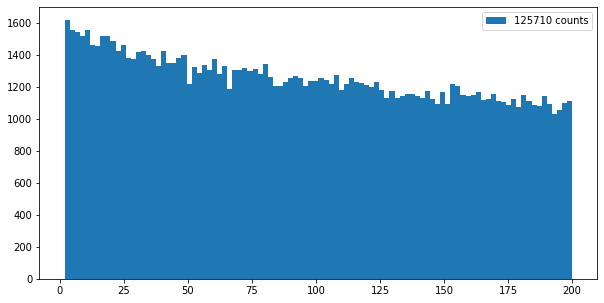

In [13]:
plt.rcParams['figure.figsize'] = (10,5)
plt.bar(bin_edge[:len(bin_edge)-1], hist_E, align='edge', width=bin_edge[1]-bin_edge[0], label=str(np.sum(hist_E))+" counts") # aligned mit linker Ecke von edge
plt.legend()

Jetzt in dem Stil das obere normieren....

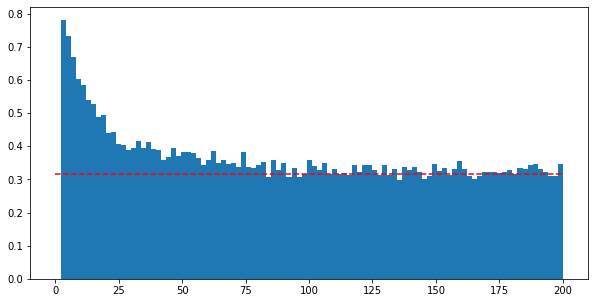

In [19]:
hist_Ex_bad, bin_Ex_bad = np.histogram(Ex_bad, bins=100)
hist_E_veri, bin_E_veri = np.histogram(ipd.E_truth_veri, bins=100)
plt.bar(bin_E_veri[:len(bin_E_veri)-1], hist_Ex_bad/hist_E_veri, align='edge', width=bin_E_veri[1]-bin_E_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, 200,  'r', linestyles="dashed")

naja so circa...? Gauß Fit ist nicht optimal, deshalb mehr als 32% der Daten ausßerhalb von $\pm \sigma$

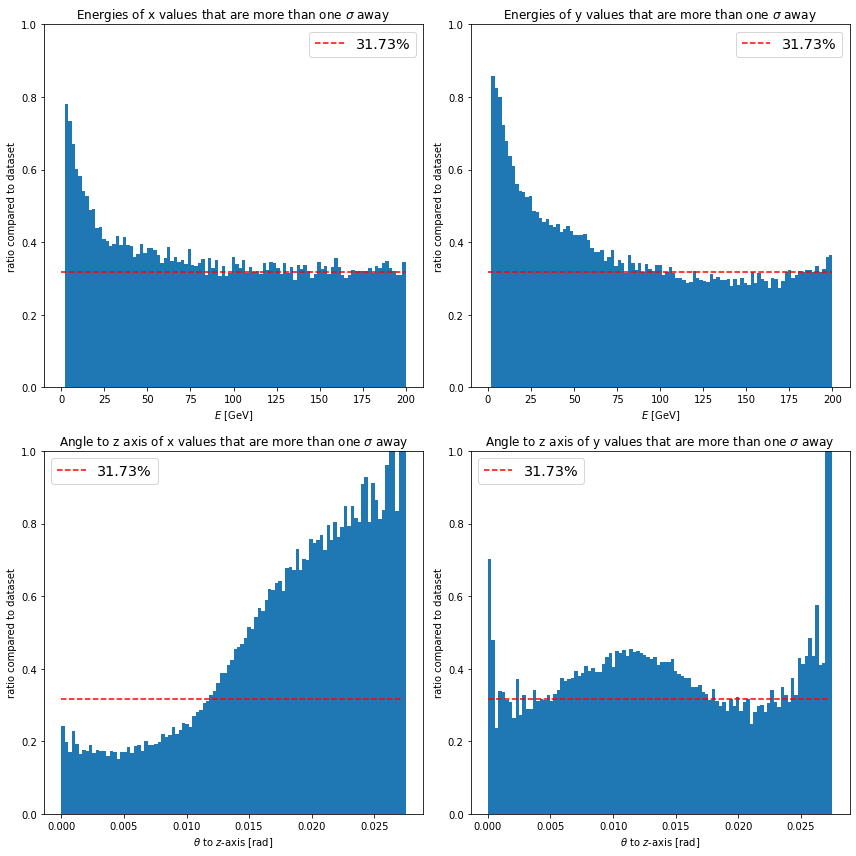

In [29]:
plt.rcParams["figure.figsize"] = (12,12)

ylim = 1

plt.subplot(2,2,1)
hist_Ex_bad, bin_Ex_bad = np.histogram(Ex_bad, bins=100)
hist_E_veri, bin_E_veri = np.histogram(ipd.E_truth_veri, bins=100)
plt.bar(bin_E_veri[:len(bin_E_veri)-1], hist_Ex_bad/hist_E_veri, align='edge', width=bin_E_veri[1]-bin_E_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, 200,  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Energies of x values that are more than one $\sigma$ away ")
plt.xlabel("$E$ [GeV]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)

plt.subplot(2,2,2)
hist_Ey_bad, bin_Ey_bad = np.histogram(Ey_bad, bins=100)
plt.bar(bin_E_veri[:len(bin_E_veri)-1], hist_Ey_bad/hist_E_veri, align='edge', width=bin_E_veri[1]-bin_E_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, 200,  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Energies of y values that are more than one $\sigma$ away ")
plt.xlabel("$E$ [GeV]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)

plt.subplot(2,2,3)
hist_theta_z_veri, bin_theta_z_veri = np.histogram(theta_z_v, bins=100)
hist_theta_z_xbad, bin_theta_z_xbad = np.histogram(theta_z_xbad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_xbad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)

plt.subplot(2,2,4)
hist_theta_z_ybad, bin_theta_z_ybad = np.histogram(theta_z_ybad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_ybad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)

plt.tight_layout()
plt.show()

Does this show what I mean? I see that big angles in z are trained very poorly for the x-position. But I need to show that these big angles are actually big angles to the x axis!

In [33]:
def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def histo_output_relxy_new(xy_NN, xy_truth, E_truth, theta_z_v, theta_x_v, theta_y_v, name='', range_x = (-0.25,0.25), bins=300, num_sig=1):
    '''similar to histo_output but written for x/y to display relative difference and return values that are more than "num_sig" times sigma away and their corresponding engery'''
    
    plt.rcParams["figure.figsize"] = (5,3)
    plt.subplot(1,1,1)
    n_counts, bins, patches = plt.hist((xy_NN-xy_truth)/xy_truth, bins=bins, range=range_x)

    x_centers = 0.5*(bins[:-1]+bins[1:])
    popt1, pcov1 = curve_fit(gaus, x_centers, n_counts, p0=[0,1, 100], sigma=1/np.sqrt(n_counts), maxfev=10000)
    perr1 = np.sqrt(np.diag(pcov1))
    x_fit = np.linspace(x_centers[0], x_centers[-1], 500)
    y_fit = gaus(x_fit, *popt1)
    plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.4f} \pm {:.4f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.4f} \pm {:.4f})$".format(popt1[1], perr1[1]))
    plt.legend()
    plt.xlabel("relative difference of true and predicted value of " + name)
    plt.ylabel("counts")

    # which values does NN not learn correctly (energy)?
    ind_bad = np.where(abs((xy_NN-xy_truth)/xy_truth) > num_sig * abs(popt1[1])) # all events further away than 1 sigma
    print("Bad indicies: ", len(ind_bad[0]))
    print("All: ", len(xy_truth))
    values_bad_xy = xy_truth[ind_bad]
    E_bad = E_truth[ind_bad]
    theta_zbad = theta_z_v[ind_bad]
    theta_xbad = theta_x_v[ind_bad]
    theta_ybad = theta_y_v[ind_bad]
    
    plt.tight_layout()
    plt.show()
    
    return values_bad_xy, E_bad, theta_zbad, theta_xbad, theta_ybad # return values that are more than 1 (num_sig) sigma away

Bad indicies:  47109
All:  125710


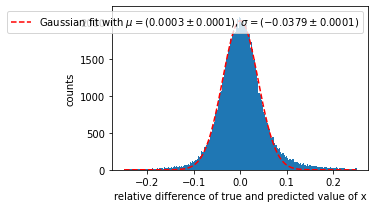

In [34]:
x_bad, Ex_bad, theta_z_xbad, theta_x_xbad, theta_y_xbad = histo_output_relxy_new(output.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], theta_z_v, theta_x_v, theta_y_v, name='x')

Bad indicies:  49061
All:  125710


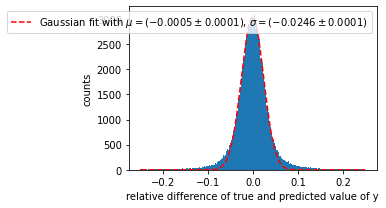

In [35]:
y_bad, Ey_bad, theta_z_ybad, theta_x_ybad, theta_y_ybad = histo_output_relxy_new(output.T[1], ipd.veri_truth.T[1], ipd.veri_truth.T[2], theta_z_v, theta_x_v, theta_y_v, name='y')

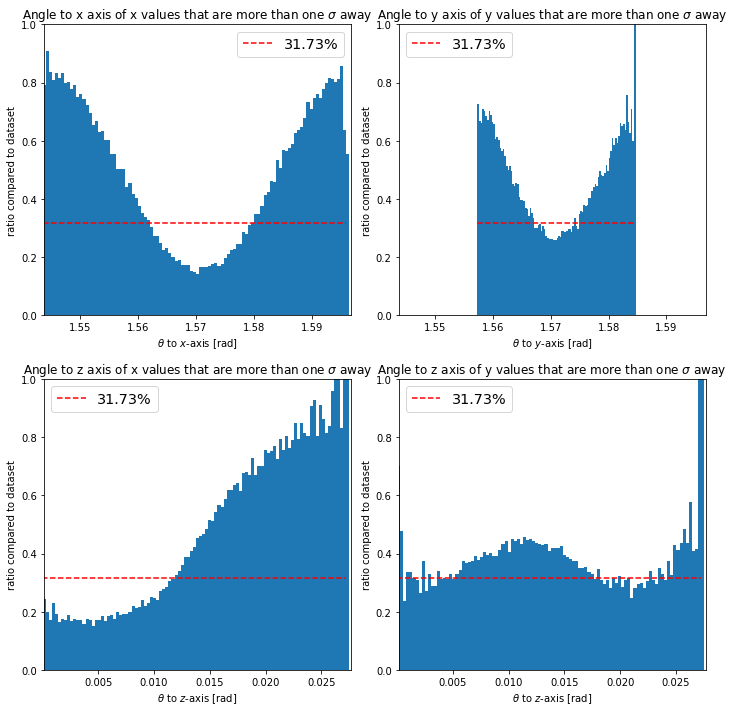

In [44]:
plt.rcParams["figure.figsize"] = (10,10) #(12,12)

ylim = 1
hist_theta_x_veri, bin_theta_x_veri = np.histogram(theta_x_v, bins=100)
hist_theta_y_veri, bin_theta_y_veri = np.histogram(theta_y_v, bins=100)
hist_theta_z_veri, bin_theta_z_veri = np.histogram(theta_z_v, bins=100)

plt.subplot(2,2,1)

hist_theta_x_xbad, bin_theta_x_xbad = np.histogram(theta_x_xbad, bins=100)
plt.bar(bin_theta_x_veri[:len(bin_theta_x_veri)-1], hist_theta_x_xbad/hist_theta_x_veri, align='edge', width=bin_theta_x_veri[1]-bin_theta_x_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, bin_theta_x_veri[0], bin_theta_x_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to x axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $x$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_x_veri[0]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2, bin_theta_x_veri[-1]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2)

plt.subplot(2,2,2)

hist_theta_y_ybad, bin_theta_y_ybad = np.histogram(theta_y_ybad, bins=100)
plt.bar(bin_theta_y_veri[:len(bin_theta_y_veri)-1], hist_theta_y_ybad/hist_theta_y_veri, align='edge', width=bin_theta_y_veri[1]-bin_theta_y_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, bin_theta_y_veri[0], bin_theta_y_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to y axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $y$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_x_veri[0]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2, bin_theta_x_veri[-1]+(bin_theta_x_veri[1]-bin_theta_x_veri[0])/2)


plt.subplot(2,2,3)


hist_theta_z_xbad, bin_theta_z_xbad = np.histogram(theta_z_xbad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_xbad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of x values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_z_veri[0]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2, bin_theta_z_veri[-1]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2)


plt.subplot(2,2,4)

hist_theta_z_ybad, bin_theta_z_ybad = np.histogram(theta_z_ybad, bins=100)
plt.bar(bin_theta_z_veri[:len(bin_theta_z_veri)-1], hist_theta_z_ybad/hist_theta_z_veri, align='edge', width=bin_theta_z_veri[1]-bin_theta_z_veri[0]) # aligned mit linker Ecke von edge
plt.hlines(0.3173, 0, bin_theta_z_veri[-2],  'r', linestyles="dashed", label="31.73%")
plt.legend(fontsize="x-large")
plt.title("Angle to z axis of y values that are more than one $\sigma$ away ")
plt.xlabel(r"$\theta$ to $z$-axis [rad]")
plt.ylabel("ratio compared to dataset")
plt.ylim(0, ylim)
plt.xlim(bin_theta_z_veri[0]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2, bin_theta_z_veri[-1]+(bin_theta_z_veri[1]-bin_theta_z_veri[0])/2)



plt.tight_layout()
plt.show()